## Magnet optimization

In [1]:
from scipy.spatial.transform import Rotation as R
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [4]:
Br = 1.43 # (T) Residual flux density for N42
mu_0 = 4 * np.pi * 10**-7 # (H/m) Permeability of free space
l = 5.08e-2 # (m) Length of cube magnet
Volume = l ** 3 # (m^3)
moment = Br * Volume / mu_0 # (A m^2)
j = Br / mu_0 # (A/m)

In [5]:
Volume = 3.0e-3 ** 3
moment_target = Br * Volume / mu_0

In [6]:
target = np.array([0.15, 0.15, 0.45]) # target position is at 40 cm above the origin
workspace_length = 0.3 # workspace is a cube of 20 cm side length
mt = np.array([moment_target, 0, 0])

In [7]:
# return the magnetic field generated by a magnet at position p and orientation r
def generate_random_pose() -> tuple[np.ndarray, np.ndarray]:
    # generate a random pose
    r = R.random()
    p = np.random.rand(3) * workspace_length
    return p, r.as_matrix()

In [332]:
def B(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ dm_i)

def F(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)

def Jb(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ dm_i)

def Jf(p_i: np.ndarray, dm_i: np.ndarray):
  r_i = target - p_i
  r_i_hat = r_i / np.linalg.norm(r_i)
  return 3 * mu_0 * moment / (4 * np.pi * np.linalg.norm(r_i) ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)

In [333]:
m = 100 # Number of random poses
K = 8 # Selection budget
d = 2 # Number of divisions for angles
n = d ** K

In [334]:
# Generating all combinations of angles
lins  = [np.linspace(0, 1.5*np.pi, d) for i in range(K)]
# lins.append(np.linspace(0, 2*np.pi, d) + np.pi/4)
angles = np.array(np.meshgrid(*lins)).T.reshape(-1, K)

In [335]:
# S is an array of tuples, each tuple contains a position and a rotation matrix
S = [generate_random_pose() for i in range(m)]

In [336]:
Bs = []
Fs = []
for p, r in S:
  m_i = np.array([0, 0, moment]) # all magnets having north pole facing upwards
  Bs.append(np.linalg.norm(B(p, m_i)))
  Fs.append(np.linalg.norm(F(p, m_i)))

Bmax = np.partition(Bs, -K)[-K:].sum() # Sum of the norms of K highest fields
Fmax = np.partition(Fs, -K)[-K:].sum() # Sum of the norms of K highest forces

In [337]:
print(Bmax, Fmax)

2.0653178041468765 0.425784110890259


In [338]:
# Initizaling A
A = np.zeros((n, K, m, 6, 6))

for t, theta in enumerate(angles):
  for i in range(K):
    for j, (p, r) in enumerate(S):
      dmagnetization = r.dot([- np.sin(theta[i]), np.cos(theta[i]), 0])
      J = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax]) 
      A[t, i, j, :, :] = np.outer(J, J)

In [339]:
# Initizaling f
f = np.zeros((n, K, m, 6, 6))

for t, theta in enumerate(angles):
  for i in range(K):
    for j, (p, r) in enumerate(S):
      magnetization = r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
      fj = np.concatenate([B(p, magnetization), F(p, magnetization)]) * 100
      f[t, i, j, :, :] = np.outer(fj, fj)

In [340]:
def A_operator(X, t):
  return cp.sum([X[i][j] * A[t, i, j] for i in range(K) for j in range(m)])

def f_operator(X):
  return sum([X[i][j] * f[t, i, j] for t in range(n) for i in range(K) for j in range(m)])

In [341]:
X = cp.Variable(shape=(K, m))
t = cp.Variable(1)

alpha = 0
# obj = cp.Maximize(t + alpha * cp.atoms.lambda_min(f_operator(X)))
obj = cp.Maximize(t)
cons1 = X >= 0.0
cons2 = X <= 1.0
cons4 = cp.sum(X) == K # sum of all elements is K
cons5 = cp.sum(X, axis=1) == 1.0 # sum of each row is 1
cons6 = cp.sum(X, axis=0) <= 1.0 # sum of each col is le 1
cons7 = t >= 0.0
constraints = [cons1, cons2, cons5, cons6]
for i in range(n):
  constraints.append(t <= cp.atoms.lambda_min(A_operator(X, i)))
prob = cp.Problem(obj, constraints)

In [342]:
# prob.solve(verbose=True)

In [343]:
prob.solve(verbose=True, solver=cp.CLARABEL)

                                     CVXPY                                     
                                     v1.5.2                                    
(CVXPY) Aug 28 10:30:04 PM: Your problem has 801 variables, 1964 constraints, and 0 parameters.
(CVXPY) Aug 28 10:30:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 28 10:30:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 28 10:30:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 28 10:30:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 28 10:30:29 PM: Compiling problem (target solver=CLARABE

1.4103057086200573e-08

In [344]:
print("Status: ", prob.status)
# print("Solution x = ", X.value)
print("Solution t = ", t.value)

Status:  optimal_inaccurate
Solution t =  [1.41030571e-08]


In [ ]:
c = plt.imshow(X.value, aspect="auto")
plt.colorbar(c)
plt.show()

## Rounding

In [13]:
def top_k(soln, k):
  result = cp.sum(soln, axis=0)
  return np.argsort(result.value)[-k:]

In [14]:
inds = top_k(X, K)
print(inds)

[19  2 80 37 82 84 23 27]


## Saving and Loading data

In [ ]:
import pickle, random
dp = dict(S=S, X=X, t=t, params={"m": m, "K": K, "d": d, "n": n})

with open("runs/checkpoint_d5.pkl", "wb") as cp_file:
    pickle.dump(dp, cp_file)

In [2]:
import pickle

dp = pickle.load(open("runs/m100_clarabel.pkl", "rb"))
X, S, t = dp["X"], dp["S"], dp["t"]
m, K, d, n = dp["params"]["m"], dp["params"]["K"], dp["params"]["d"], dp["params"]["n"]

In [3]:
t.value

array([1.94351159e-08])

## Histogram of singular values

In [250]:
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt

In [251]:
inds = top_k(X, K)
singular_values = []
for theta in angles:
  J = np.zeros((K, 6))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
    Ji = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
    J[i] = Ji
  _, s, _ = sp.svds(J, k=1, which='SM')
  singular_values.append(s[0])
	  

In [ ]:
print(len(angles))

In [ ]:
print(len(singular_values))

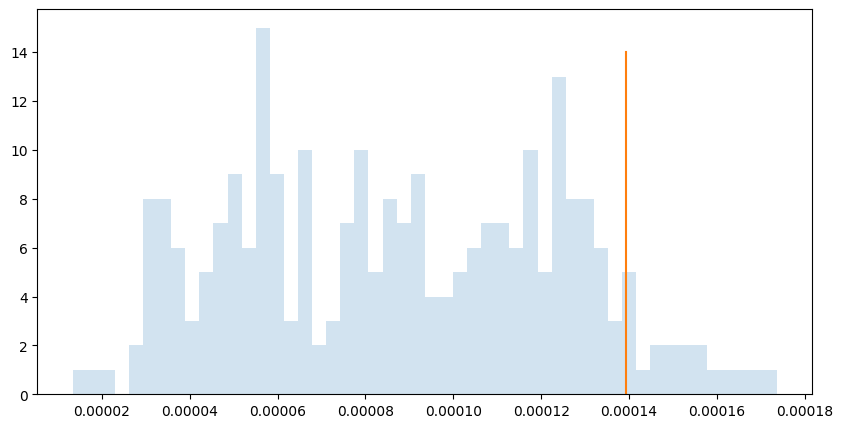

In [255]:
plt.hist(singular_values, bins=50, alpha=0.2)
plt.plot([np.sqrt(t.value)[0], np.sqrt(t.value)[0]], [0,14], ls="-")
# plt.plot([t.value, t.value], [0,6], ls="-")
plt.gcf().set_size_inches(10, 5)
plt.show()

In [ ]:
inds = np.random.randint(0, m, K)
singular_values_random = []
for theta in angles:
  J = np.zeros((K, 6))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
    Ji = np.concatenate([Jb(p, dmagnetization)/Bmax, Jf(p, dmagnetization)/Fmax])
    J[i] = Ji
  _, s, _ = sp.svds(J, k=1, which='SM')
  singular_values_random.append(s[0])

## Histogram of unrounded solution

In [266]:
singular_values = []

for i in range(n):
  singular_values.append(cp.atoms.lambda_min(A_operator(X, i)).value)

In [ ]:
min(singular_values)

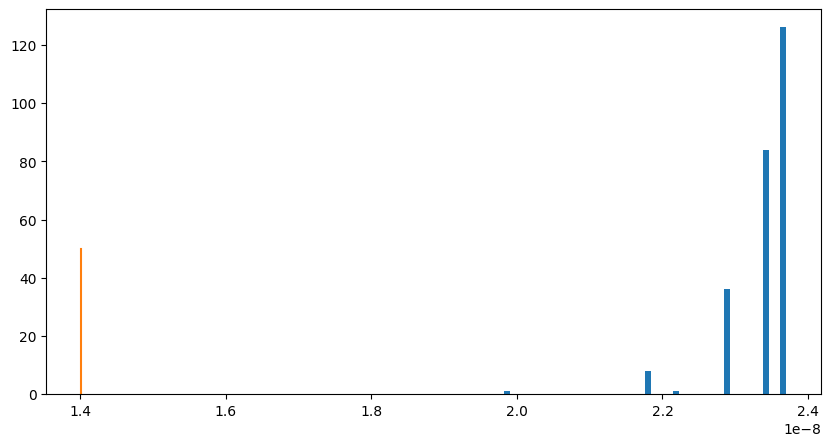

In [272]:
plt.hist(singular_values, bins=50)
plt.gcf().set_size_inches(10, 5)
plt.plot([t.value, t.value], [0,50], ls="-")
plt.show()

## Bruteforce

In [ ]:
from itertools import combinations
m_list = list(range(m))
combinations = list(combinations(m_list, K))
ts = []
for inds in combinations:
  singular_values = []
  for t in angles:
    J = np.zeros((6, K))
    for i, ind in enumerate(inds):
      p, r = S[ind]
      dm = r.dot([- np.sin(angles[0][i]), np.cos(angles[0][i]), 0])
      J[:, i] = np.concatenate([Jb(p, dm)/Bmax, Jf(p, dm)/Fmax])
    _, s, _ = sp.svds(J, k=1, which='SM')
    singular_values.append(s[0])
  ts.append(min(singular_values))
    

## Evalulation

In [ ]:
from scipy.optimize import minimize

In [ ]:
force_x(np.random.rand(K) * 2*np.pi)

In [ ]:
def force_x(x):
  total_force_x = 0.
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_force_x += np.abs(F(p, m_i)[0])
    # What to do for jac abs
  return -1. * total_force_x

def force_x_grad(x):
  jac = np.array([])
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    jac = np.append(abs(jac), Jf(p, m_i)[1])
  return jac
    

In [ ]:
x0 = np.random.rand(K) * 2*np.pi
print(x0)
bounds = [(0, 2 * np.pi)] * K
res = minimize(force_x, x0, method='CG', jac=force_x_grad,
               options={'gtol': 1e-6, 'disp': True})

In [ ]:
print(res.x)

In [ ]:
print(force_x(res.x))

## Diagram of chosen

In [240]:
rs = [R.from_matrix(S[i][1]) for i in inds]
# convert rs to quaternions with y and z axis swapped
quats = [r.as_quat() for r in rs]
quats = np.array([[q[0], q[2], q[1], q[3]] for q in quats])
print("{")
for q in quats:
  print("new Quaternion(%ff, %ff, %ff, %ff)," % (q[0], q[1], q[2], q[3]))
print("}")


{
new Quaternion(-0.273802f, 0.075165f, 0.951945f, -0.114815f),
new Quaternion(-0.041797f, -0.130365f, -0.045356f, 0.989546f),
new Quaternion(-0.176862f, -0.020025f, 0.881022f, 0.438314f),
new Quaternion(-0.494383f, -0.108739f, 0.416748f, 0.755038f),
new Quaternion(0.235692f, 0.702588f, -0.273547f, 0.613181f),
new Quaternion(0.228891f, -0.576798f, 0.218201f, 0.753194f),
new Quaternion(0.807927f, -0.465929f, 0.222933f, -0.283665f),
new Quaternion(0.641211f, 0.704626f, 0.301096f, -0.041119f),
}


In [242]:
# Get x, y, z components of the S
x = [s[0] for s, _ in S]
y = [s[1] for s, _ in S]
z = [s[2] for s, _ in S] 

inds = top_k(X, K)

xc = [S[i][0][0] for i in inds]
yc = [S[i][0][1] for i in inds]
zc = [S[i][0][2] for i in inds] 

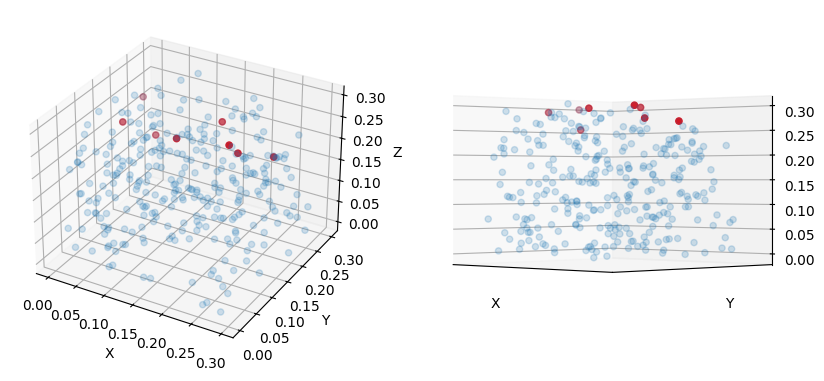

In [243]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221, projection='3d')

ax1.scatter(x, y, z, alpha=0.2)
ax1.scatter(xc, yc, zc, c='red')

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(222, projection='3d')

ax2.scatter(x, y, z, alpha=0.2)
ax2.scatter(xc, yc, zc, c='red')

# remove axis values
ax2.set_xticks([])
ax2.set_yticks([])

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
# rotate axe2
ax2.view_init(0, -45)


plt.show()

## Control

In [19]:
from scipy.optimize import minimize

In [9]:
Kc = np.sqrt(Bmax)/(np.sqrt(Fmax) + np.sqrt(Bmax))
# Kc = 0.5

In [15]:
def force(x):
  total_force = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_force += F(p, m_i)
  return total_force

def force_jac(x):
  total_force = np.zeros((3, K))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_force[:, i] = Jf(p, m_i)
  return total_force

def force_jac2(x):
  total_force = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_force += Jf(p, m_i)
  return total_force

def field(x):
  total_field = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([np.cos(x[i]), np.sin(x[i]), 0])
    total_field += B(p, m_i)
  return total_field

def field_jac(x):
  total_field = np.zeros((3, K))
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_field[:, i] = Jb(p, m_i)
  return total_field

def field_jac2(x):
  total_field = np.zeros(3)
  for i, ind in enumerate(inds):
    p, r = S[ind]
    m_i = r.dot([-np.sin(x[i]), np.cos(x[i]), 0])
    total_field  += Jb(p, m_i)
  return total_field

B0 = field(np.zeros(K))
F0 = force(np.zeros(K))

print("Force: ", field(np.zeros(K)))
print("Field: ", field_jac(np.zeros(K)))
field_jac2(np.zeros(K))

Force:  [-0.00286758  0.00862937  0.00152854]
Field:  [[-0.00250254  0.00047055 -0.00591485 -0.00029197  0.00060637  0.00281164
  -0.00386934 -0.00090468]
 [ 0.00059385 -0.00078418 -0.00037089  0.00047511  0.0016411   0.00325529
  -0.00312399  0.0006335 ]
 [ 0.00313952  0.00215106 -0.00778288  0.00318129  0.00045406  0.00244502
   0.00228126  0.00082185]]


array([-0.00959481,  0.00231979,  0.00669118])

In [179]:
def control_f(x):
  return (1.0-Kc) * (np.linalg.norm(force(x) - F0)) ** 2 + Kc * (np.linalg.norm(field(x) - B0)) ** 2
def control_f_jac(x):
  return 2.0 * (1.0-Kc) * (force(x) - F0) @ force_jac(x) + 2.0 * Kc * (field(x) - B0) @  field_jac(x)

In [ ]:
rr = np.random.rand(K) * 2*np.pi
print(control_f(rr))
control_f(rr)

In [84]:
# Max force
def control_f(x):
  return -1 * ((1.0-Kc) * np.linalg.norm(force(x)) ** 2 - Kc * (np.linalg.norm(field(x) - B0)) ** 2)
def control_f_jac(x):
  return -1 * (2.0 * (1.0-Kc) * (force(x)) @ force_jac(x) - 2.0 * Kc * (field(x) - B0) @  field_jac(x))

In [178]:
# Max field
def control_f(x):
  return -1 * (-1 * (1.0-Kc) * np.linalg.norm(force(x) - F0) ** 2 + Kc * (np.linalg.norm(field(x))) ** 2)
def control_f_jac(x):
  return -1 * (-2.0 * (1.0-Kc) * (force(x)-F0) @ force_jac(x) + 2.0 * Kc * (field(x)) @  field_jac(x))

In [180]:
# F0 = np.array([ 0.0,  0.0, 0.001])
# B0 = np.array([ 0.0,  0.0, 0.001])
# F0 = np.array([ 0.0,  0.01, 0.0])
# B0 = np.array([ 0.0,  0.0001, 0.0])
F0 = np.array([ 0.0, 0.0, 0.0])
B0 = np.array([ 0.0, 0.01, 0.0])

x0 = np.random.rand(K) * 2*np.pi
print(x0)
print(force(x0))
res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
               options={'gtol': 1e-12, 'disp': True, 'maxiter': 1000})

[5.21326585 3.97949398 4.38572587 5.77612212 0.83209128 2.0740921
 0.79843969 0.19913783]
[-1.22827210e-03  5.23373089e-04  2.99567335e-05]
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 191
         Function evaluations: 201
         Gradient evaluations: 201


In [181]:
print(field(res.x)  - B0)
print(force(res.x) - F0)
print("field: ", field(res.x))
print("force: ", force(res.x))

[-3.01770765e-04 -1.40448622e-03 -9.67441901e-05]
[-0.00045355 -0.00131851  0.00011346]
field:  [-3.01770765e-04  8.59551378e-03 -9.67441901e-05]
force:  [-0.00045355 -0.00131851  0.00011346]


In [120]:
print(coll.getB([0.15, 0.15, 0.5]))


[ 3.90659253e-04 -7.05323706e-04 -5.62142352e-05]


In [17]:
BF0 = [
  ([ 0.0001,  0.0, 0.0], [ 0.001,  0.0, 0.0]), 
  ([ 0.0,  0.0001, 0.0], [ 0.0,  0.001, 0.0]), 
  ([ 0.0,  0.0, 0.0001], [ 0.0,  0.0, 0.001]),
  ([ 0.0,  0.0001, 0.0001], [ 0.0,  0.001, 0.001])
  ]

In [121]:
res.x = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [182]:
results = []
results.append(res.x)

In [20]:
results = []
for i in BF0:
  B0, F0 = i[0], i[1] 
  x0 = np.random.rand(K) * 2*np.pi
  res = minimize(control_f, x0, method='BFGS', jac=control_f_jac,
                options={'gtol': 1e-12, 'maxiter': 1000})
  print(res.success)
  results.append(res.x)

True
True
True
True


In [71]:
import magpylib as magpy
from numpy.linalg import norm

[-9.10366373e+02  4.69930862e-03 -8.41984715e-04]


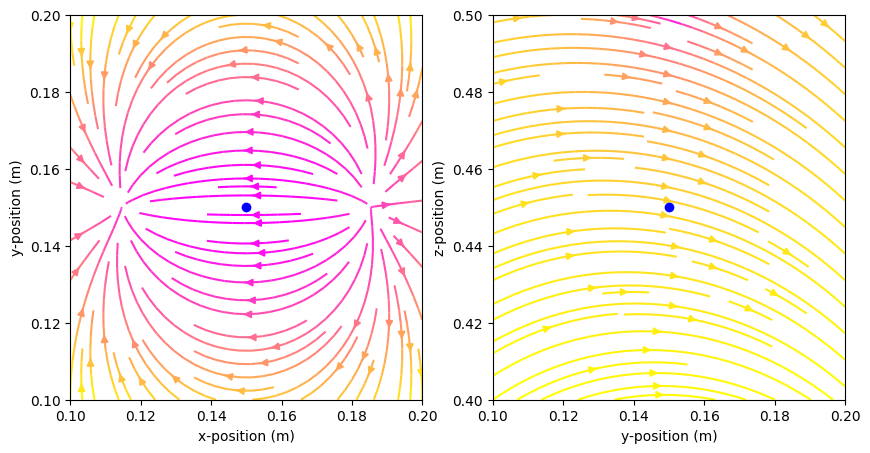

In [195]:

coll = magpy.Collection()
j = Br / mu_0 
inds = top_k(X, K)

# Create an observer grid in the xy-symmetry plane
grid = np.mgrid[0.1:0.2:50j, 0.1:0.2:50j, 0.45:0.45:1j].T[0]
X, Y, _ = np.moveaxis(grid, 2, 0)

# Create an observer grid in the yz-symmetry plane
grid2 = np.array([[(0.15, y, z) for y in np.linspace(0.1, 0.2, 50)] for z in np.linspace(0.4, 0.5, 50)])
_, Y2, Z2 = np.moveaxis(grid2, 2, 0)

for ind, i in enumerate(inds):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    angles = [r[ind] for r in results]
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(angles, axis=r.dot([0, 0, 1]), start=0, degrees=False))
# for m in coll:
    # m.rotate_from_angax(0, axis=r.dot([0, 0, 1]), start=0, degrees=False))

moments = [[0, 0, 90], [0, -90, 0], [0, -45, 45]]
# dip = magpy.misc.Dipole(moment=BF0[0][1], position=[0, 0, 0.4])
# coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(3.0e-3, 3.0e-3, 3.0e-3), position=target, style_magnetization_mode='arrow'))
coll.add(magpy.misc.Dipole(moment=(j, 0, 0), position=target, style_color='red', style_size=1.5))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

print(coll.getB([0.15, 0.15, 0.45]))
b = coll.getB(grid)
Bx, By, _ = np.moveaxis(b, 2, 0)

b2 = coll.getB(grid2)
_, By2, Bz2 = np.moveaxis(b2, 2, 0)

fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(10, 5))
ax1.streamplot(X, Y, Bx, By, color=np.log(norm(b, axis=2)), cmap="spring_r")
ax1.plot(0.15, 0.15, 'bo')
ax2.streamplot(Y2, Z2, By2, Bz2, color=np.log(norm(b2, axis=2)), cmap="spring_r")
ax2.plot(0.15, 0.45, 'bo')

ax1.set(
    xlabel="x-position (m)",
    ylabel="y-position (m)",
    xlim=(0.1, 0.2),
    ylim=(0.1, 0.2),
)

ax2.set(
    xlabel="y-position (m)",
    ylabel="z-position (m)",
    xlim=(0.1, 0.2),
    ylim=(0.4, 0.5),
)
magpy.show(coll, animation=False)


In [66]:
coll = magpy.Collection()

inds = top_k(X, K)

for ind, i in enumerate(inds):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    angles = [r[ind] for r in results]
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(angles, axis=r.dot([0, 0, 1]), start=0, degrees=False))

moments = [[0, 0, 90], [0, -90, 0], [0, -45, 45]]
# dip = magpy.misc.Dipole(moment=BF0[0][1], position=[0, 0, 0.4])
coll.add(magpy.misc.Dipole(moment=BF0[0][1], position=target, style_color='red', style_size=3.5).rotate_from_euler(moments, "xyz"))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)


In [21]:
for ind, i in enumerate(BF0):
  print(i)
  print("B0: ", i[0])
  print("F0: ", i[1])
  print("Error in field", field(results[ind])  - i[0])
  print("Error in Force", force(results[ind]) - i[1])
  print()

([0.0001, 0.0, 0.0], [0.001, 0.0, 0.0])
B0:  [0.0001, 0.0, 0.0]
F0:  [0.001, 0.0, 0.0]
Error in field [ 0.00041833 -0.0002855   0.00025807]
Error in Force [-1.83272062e-03  5.13821552e-04  2.89098177e-05]

([0.0, 0.0001, 0.0], [0.0, 0.001, 0.0])
B0:  [0.0, 0.0001, 0.0]
F0:  [0.0, 0.001, 0.0]
Error in field [-1.51704856e-04  1.75277029e-04  5.09488895e-05]
Error in Force [ 0.00027488 -0.00062264 -0.00054917]

([0.0, 0.0, 0.0001], [0.0, 0.0, 0.001])
B0:  [0.0, 0.0, 0.0001]
F0:  [0.0, 0.0, 0.001]
Error in field [ 5.08236352e-11 -2.87361465e-11  8.81689402e-12]
Error in Force [-3.49926997e-11  2.79372434e-12 -2.61233858e-11]

([0.0, 0.0001, 0.0001], [0.0, 0.001, 0.001])
B0:  [0.0, 0.0001, 0.0001]
F0:  [0.0, 0.001, 0.001]
Error in field [ 9.97545536e-05 -6.66723350e-05 -1.33485025e-05]
Error in Force [-3.19770062e-05  3.46696214e-05  2.97382914e-04]



## Testing Patrick's design

In [ ]:
# Magnet Positions (deg) Rotational Axes (deg)
#    α  φ    β  ξ
# 1 335 115 70 60
# 2 40 105 225 145
# 3 235 112 315 20
# 4 90 45 148 235
# 5 198 45 265 260
# 6 305 55 25 225
# 7 70 180 275 90
# 8 166 115 350 130
r = 0.075
spherical_magnet_positions = [[335, 115], [40, 105], [235, 112], [90, 45], [198, 45], [305, 55], [70, 180], [166, 115]]
spherical_rotational_axes = [[70, 60], [225, 145], [315, 20], [148, 235], [265, 260], [25, 225], [275, 90], [350, 130]]
cartesian_magnet_positions = [ [r * np.sin(np.deg2rad(theta)) * np.cos(np.deg2rad(phi)),
                                r * np.sin(np.deg2rad(theta)) * np.sin(np.deg2rad(phi)),
                                r * np.cos(np.deg2rad(theta))] 
                              for phi, theta in spherical_magnet_positions]
cartesian_rotational_axes = [ [np.sin(np.deg2rad(alpha)) * np.cos(np.deg2rad(beta)),
                               np.sin(np.deg2rad(alpha)) * np.sin(np.deg2rad(beta)),
                               np.cos(np.deg2rad(beta))] 
                             for beta, alpha in spherical_rotational_axes]
moment = 16.6 # (A m^2)

In [ ]:
import magpylib as magpy

coll = magpy.Collection()

for i in range(8):
    p = cartesian_magnet_positions[i]
    # print(p, cartesian_rotational_axes[i])
    # r = R.from_rotvec(cartesian_rotational_axes[i])
    r = R.from_euler('ZY', spherical_rotational_axes[i], degrees=True)
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    axis = r.as_matrix().dot([0, 0, 1])
    # print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r))).rotate_from_angax(np.linspace(0, 360, 30), axis=axis, start=0)
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=r, style_magnetization_mode='arrow').rotate_from_angax(np.linspace(0, 360, 30), axis=r.as_matrix().dot([0, 0, 1]), start=0))

# coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
# magpy.show(coll2)

In [ ]:
r_i_hat = np.array([0, 0, 1])
dm_i = np.array([0, 0, 1])
mt = np.array([0, 0, 10e-6])
bmax = mu_0 * moment * 8 / (4 * np.pi * r ** 3) * ((3 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) @ np.array([0, 0, 1]))
fmax = 3 * mu_0 * moment * 8 / (4 * np.pi * r ** 4) \
    * np.dot(
      np.outer(dm_i, r_i_hat) + 
      np.outer(r_i_hat, dm_i) - 
      ((5 * np.outer(r_i_hat, r_i_hat) - np.eye(3)) * np.dot(dm_i, r_i_hat))
      , mt)
bmax = np.linalg.norm(bmax)
fmax = np.linalg.norm(fmax)
print(bmax, fmax)

In [ ]:
singular_values = []
for theta in angles:
  J = np.zeros((6, 8))
  for i in range(8):
    p = cartesian_magnet_positions[i]
    r = R.from_euler('ZY', spherical_rotational_axes[i], degrees=True).as_matrix()
    dmagnetization = r.dot([-np.sin(theta[i]), np.cos(theta[i]), 0])
    Ji = np.concatenate([Jb(p, dmagnetization)/bmax, Jf(p, dmagnetization)/fmax])
    J[:, i] = Ji
  _, s, _ = sp.svds(J, k=1, which='SM')
  singular_values.append(s[0])
	  

In [ ]:
print(np.min(singular_values))

In [ ]:
plt.hist(singular_values, bins=50)
plt.gcf().set_size_inches(10, 5)
plt.show()

## TESTING STUFF BELOW

In [ ]:
theta = 0.5
p = [np.cos(theta), np.sin(theta), 0]
r = R.random()
p1 = r.as_matrix().dot(p)
p_r, r_r = generate_random_pose()
print(Jb(p_r, p1))
print(Jf(p_r, p1))
np.concatenate([Jb(p_r, p1), Jf(p_r, p1)])

In [ ]:
x = cp.Variable(1)
t = cp.Variable(1)

obj = cp.Maximize(t)
cons1 = x >= 0.0
cons2 = x <= 10.0
cons3 = t <= -x
prob = cp.Problem(obj, [cons1, cons2, cons3])
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
prob.solve()

print("Status: ", prob.status)
print("Solution x = ", x.value)
print("Solution t = ", t.value)

In [ ]:
test = cp.Constant(np.array([[1, 2, 3], [4, 5, 6]]))

In [ ]:
bl = cp.Constant(np.array([[1, 0, 1], [1, 0, 0]])) 
blsum = bl <= 1.0
blsum.value()

In [ ]:
cp.sum(test, 0).value

In [ ]:
theta = 0
p = [np.cos(theta), np.sin(theta), 0]

In [ ]:
def are_points_too_close(self, ind):
    for i in range(0, self.n * 2, 2):
        for j in range(i+2, self.n * 2, 2):
            dis = np.sqrt((ind[i] - ind[j])**2 + (ind[i+1] - ind[j+1])**2)
            if dis < self.min_distance:
                return True
    return False

## Visualization

In [ ]:
import magpylib as magpy

coll = magpy.Collection()

j = Br / mu_0 
inds = top_k(X, K)

for i in inds:
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    coll.add(magpy.magnet.Cuboid(magnetization=(j, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)).rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0))
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))

magpy.show(coll, animation=True)

## Testing visualization stuff

In [9]:
r = R.random()
print(r.as_euler('ZYX', degrees=True))

[-24.01941058 -34.92595964 171.38915377]


[array([ 0.        ,  0.        ,  0.        ,  0.74889611, -0.33373408,
        0.57251741]), array([ 0.        ,  0.        ,  0.        , -0.48075406, -0.86822025,
        0.12275638]), array([ 0.        ,  0.        ,  0.        ,  0.45610322, -0.36717184,
       -0.81065078])]


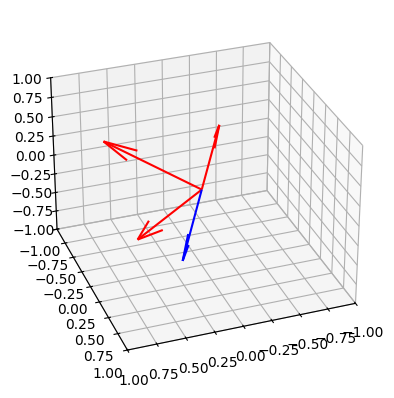

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# rotates around x, y

theta = 3.14+1.57
p = [np.cos(theta), np.sin(theta), 0]
xyz = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
# r = R.from_euler('ZYX', [45, 0, 90], degrees=True)
p1 = r.as_matrix().dot(p)
p2s = [np.concatenate(([0, 0, 0], r.as_matrix().dot(x))) for x in xyz]
print(p2s)
# soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
# p2s.append([0, 0, 0, p1[0], p1[1], p1[2]])
soa = np.array(p2s)

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color='r')
soa = np.array([[0, 0, 0, p1[0], p1[1], p1[2]]])
X, Y, Z, U, V, W = zip(*soa)
ax.quiver(X, Y, Z, U, V, W, color='b')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.view_init(30, 70) 
plt.show()

In [132]:
import magpylib as magpy

coll = magpy.Collection()
coll2 = magpy.Collection()

for i in range(1):
    p, r = S[i]
    # magpy.magnet.Cuboid(magnetization=(M,0,0), dimension=(0.02,0.01,0.05), position=(-0.074806,0,0))
    theta = 1.57
    print(r.dot([np.cos(theta), np.sin(theta), 0]))
    # coll.add(magpy.magnet.Sphere(magnetization=(J, 0, 0), dimension=(l, l, l), position=p, orientation=R.from_matrix(r)))
    coll.add(magpy.magnet.Sphere(magnetization=(j, 0, 0), diameter=l, position=p, orientation=R.from_matrix(r), style_magnetization_mode='arrow'))
    coll2.add(magpy.magnet.Sphere(magnetization=j*r.dot([np.cos(theta), np.sin(theta), 0]), diameter=l, position=p,  style_magnetization_mode='arrow'))
coll[0].rotate_from_angax(np.linspace(0, 90, 30), axis=r.dot([0, 0, 1]), start=0)
# r.dot([np.cos(theta[i]), np.sin(theta[i]), 0])
# coll.add(magpy.magnet.Cuboid(magnetization=(J, 0, 0), dimension=(l, l, l), position=p))
magpy.show(coll, animation=True)
magpy.show(coll2)

[ 0.63374539 -0.76234916 -0.13111268]


In [ ]:
import numpy as np

In [ ]:
for i in range(100):
  print(127 + 127 * np.sin(2 * np.pi * i / 100), end=", ")